# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [2]:
df = pd.read_csv(r"tweet_sentiment_train.csv/train.csv")

In [3]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [4]:
df.dtypes

textID           object
text             object
selected_text    object
sentiment        object
dtype: object

In [5]:
df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
len(df)

27480

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



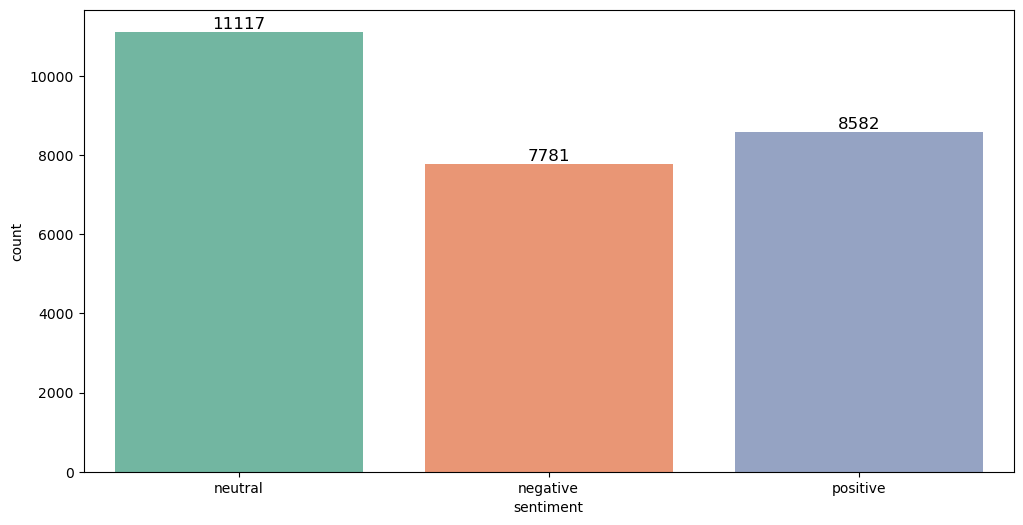

In [8]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment', hue='sentiment', data=df, palette='Set2')

for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height(), int(p.get_height()), 
             ha='center', va='bottom', fontsize=12)
    
plt.show()

Бачимо, що найбільше у нас кейсів з нейтральним настороєм, а найменше - з негативним.

In [9]:
df['text_length'] = df['text'].str.len()

In [10]:
df

,textID,text,selected_text,sentiment,text_length
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46
2,088c60f138,my boss is bullying me...,bullying me,negative,25
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,77
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,122
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,111
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,27


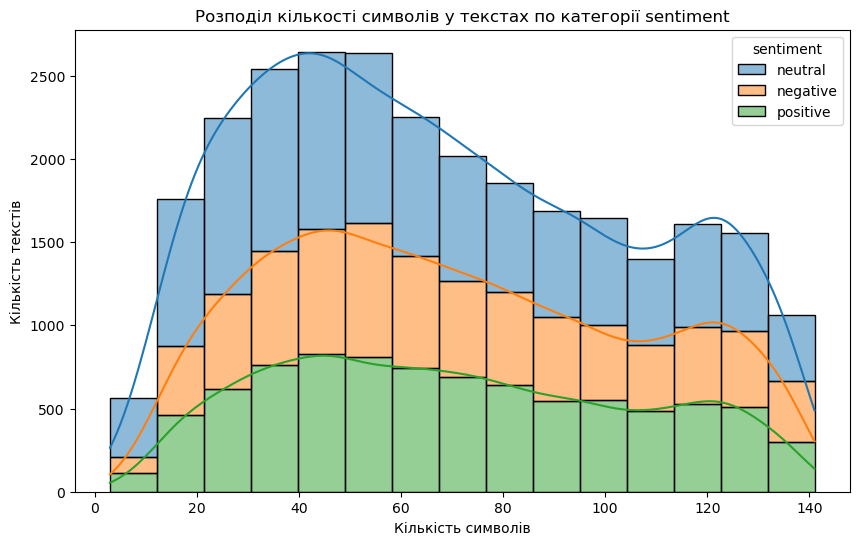

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', bins=15, kde=True, hue='sentiment', multiple='stack')
plt.title('Розподіл кількості символів у текстах по категорії sentiment')
plt.xlabel('Кількість символів')
plt.ylabel('Кількість текстів')
plt.show()

In [12]:
# Групуємо дані за категорією sentiment і обчислюємо середню кількість символів
mean_text_length = df.groupby('sentiment')['text_length'].mean()
mean_text_length

sentiment
negative    70.488112
neutral     65.206800
positive    70.419133
Name: text_length, dtype: float64

Найбільше текстів з довжиною 30-60 символів, найменше символів в нейтральній категорії (65 символів), в той час як для позитивних і негативних категорій кількість символів в середньому майже однакова - 70 символів.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [13]:
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer(language='english')

In [14]:
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)
    tokens = word_tokenize(text.lower())
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [15]:
# nltk.download('punkt')
df['processed_text'] = df['text'].apply(preprocess_text)

In [16]:
# Використовуємо CountVectorizer без обмеження кількості слів
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['processed_text'])

# Підрахуємо частоту кожного слова
word_freq = X.toarray().sum(axis=0)
vocab = vectorizer.get_feature_names_out()

word_freq_df = pd.DataFrame({'word': vocab, 'frequency': word_freq})
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

print("Топ 100 слів за частотою:")
print(word_freq_df.head(100))

print(f"Загальна кількість унікальних слів: {len(vocab)}")

Топ 100 слів за частотою:
        word  frequency
6208     day       2451
8845      go       2383
8688     get       1916
8891    good       1599
20804   work       1529
...      ...        ...
8755    girl        304
17490   soon        303
19845    use        302
9666     hey        299
11781  littl        298

[100 rows x 2 columns]
Загальна кількість унікальних слів: 21454


In [17]:
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer(max_features=500)

X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)


print("Словник з обмеженням до 500 слів:")
print(vectorizer.get_feature_names_out())

Словник з обмеженням до 500 слів:
['10' '30' '4th' 'abl' 'account' 'actual' 'ago' 'agre' 'ah' 'almost'
 'alon' 'alreadi' 'also' 'alway' 'amaz' 'anoth' 'anymor' 'anyon' 'anyth'
 'anyway' 'around' 'ask' 'aw' 'awak' 'away' 'awesom' 'aww' 'awww' 'babi'
 'back' 'bad' 'bank' 'beach' 'beauti' 'bed' 'believ' 'best' 'better' 'big'
 'birthday' 'bit' 'bless' 'blip' 'blog' 'boo' 'book' 'bore' 'bought'
 'bout' 'boy' 'break' 'breakfast' 'bring' 'broke' 'brother' 'btw' 'busi'
 'buy' 'cake' 'call' 'came' 'cant' 'car' 'card' 'care' 'cat' 'catch'
 'caus' 'chang' 'check' 'chocol' 'citi' 'class' 'clean' 'close' 'coffe'
 'cold' 'com' 'come' 'comput' 'concert' 'cool' 'could' 'coupl' 'crazi'
 'cream' 'cri' 'cute' 'cuz' 'dad' 'danc' 'date' 'day' 'dead' 'definit'
 'didnt' 'die' 'differ' 'dinner' 'dog' 'done' 'dont' 'download' 'dream'
 'drink' 'drive' 'dude' 'due' 'earli' 'eat' 'either' 'els' 'email' 'end'
 'enjoy' 'enough' 'episod' 'even' 'ever' 'everi' 'everyon' 'everyth'
 'exam' 'excit' 'eye' 'face' 'faceboo

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [18]:
#Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_bow, y_train)
y_pred_logreg = logreg.predict(X_test_bow)

#Decision Tree
tree = DecisionTreeClassifier()
tree.fit(X_train_bow, y_train)
y_pred_tree = tree.predict(X_test_bow)

#Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train_bow, y_train)
y_pred_gb = gb.predict(X_test_bow)

In [19]:
print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg)}")
print("Звіт про класифікацію:\n", classification_report(y_test, y_pred_logreg))

print("\nDecision Tree:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree)}")
print("Звіт про класифікацію:\n", classification_report(y_test, y_pred_tree))

print("\nGradient Boosting:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb)}")
print("Звіт про класифікацію:\n", classification_report(y_test, y_pred_gb))

best_model = logreg
print("\nConfusion Matrix для Logistic Regression:")
print(confusion_matrix(y_test, y_pred_logreg))

Logistic Regression:
Accuracy: 0.6779475982532751
Звіт про класифікацію:
               precision    recall  f1-score   support

    negative       0.71      0.52      0.60      1572
     neutral       0.62      0.76      0.68      2236
    positive       0.76      0.71      0.74      1688

    accuracy                           0.68      5496
   macro avg       0.70      0.67      0.67      5496
weighted avg       0.69      0.68      0.68      5496


Decision Tree:
Accuracy: 0.5998908296943232
Звіт про класифікацію:
               precision    recall  f1-score   support

    negative       0.55      0.58      0.56      1572
     neutral       0.59      0.59      0.59      2236
    positive       0.67      0.63      0.65      1688

    accuracy                           0.60      5496
   macro avg       0.60      0.60      0.60      5496
weighted avg       0.60      0.60      0.60      5496


Gradient Boosting:
Accuracy: 0.660844250363901
Звіт про класифікацію:
               precision

Бачимо, що найбільшу якість має логістична регресія, яка має точність приблизно 68%.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [20]:
feature_importance = pd.Series(logreg.coef_[0], index=vectorizer.get_feature_names_out(), name='imp').sort_values(ascending=False)
feature_importance

sad       2.386876
suck      2.150363
hate      2.110938
sorri     2.031382
bore      2.030732
            ...   
thank    -1.805441
cute     -1.862890
love     -1.917243
glad     -2.181077
awesom   -2.385371
Name: imp, Length: 500, dtype: float64

In [21]:
feature_importance[:20]

sad        2.386876
suck       2.150363
hate       2.110938
sorri      2.031382
bore       2.030732
fail       2.022935
poor       1.921879
hurt       1.800630
miss       1.769949
stupid     1.769753
sick       1.717171
headach    1.714078
tire       1.561090
wrong      1.483771
pain       1.449561
cri        1.418215
ugh        1.328470
broke      1.284935
stuck      1.273043
bad        1.255569
Name: imp, dtype: float64

В цілому, більшість слів, які ми бачимо на горі дійсно вживається для вираження негативного настрою, тому цей список виглядає логічно

In [22]:
feature_importance[-10:]

beauti   -1.460486
enjoy    -1.524072
smile    -1.572829
welcom   -1.737509
amaz     -1.755268
thank    -1.805441
cute     -1.862890
love     -1.917243
glad     -2.181077
awesom   -2.385371
Name: imp, dtype: float64

Тут така сама ситуація, ці слова виглядають дуже комплементарно і означають позитивний настрій.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [23]:
# Створюємо об'єкт для обчислення TF-IDF
vectorizer = TfidfVectorizer()

# Обчислюємо TF-IDF для наших документів
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [24]:
#Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tfidf, y_train)
y_pred_logreg = logreg.predict(X_test_tfidf)

#Decision Tree
tree = DecisionTreeClassifier()
tree.fit(X_train_tfidf, y_train)
y_pred_tree = tree.predict(X_test_tfidf)

#Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train_tfidf, y_train)
y_pred_gb = gb.predict(X_test_tfidf)

In [25]:
print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg)}")
print("Звіт про класифікацію:\n", classification_report(y_test, y_pred_logreg))

print("\nDecision Tree:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree)}")
print("Звіт про класифікацію:\n", classification_report(y_test, y_pred_tree))

print("\nGradient Boosting:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb)}")
print("Звіт про класифікацію:\n", classification_report(y_test, y_pred_gb))

best_model = logreg
print("\nConfusion Matrix для Logistic Regression:")
print(confusion_matrix(y_test, y_pred_logreg))

Logistic Regression:
Accuracy: 0.6834061135371179
Звіт про класифікацію:
               precision    recall  f1-score   support

    negative       0.71      0.57      0.63      1572
     neutral       0.63      0.75      0.68      2236
    positive       0.76      0.70      0.73      1688

    accuracy                           0.68      5496
   macro avg       0.70      0.67      0.68      5496
weighted avg       0.69      0.68      0.68      5496


Decision Tree:
Accuracy: 0.6570232896652111
Звіт про класифікацію:
               precision    recall  f1-score   support

    negative       0.64      0.60      0.62      1572
     neutral       0.64      0.65      0.65      2236
    positive       0.69      0.72      0.70      1688

    accuracy                           0.66      5496
   macro avg       0.66      0.66      0.66      5496
weighted avg       0.66      0.66      0.66      5496


Gradient Boosting:
Accuracy: 0.6639374090247453
Звіт про класифікацію:
               precisio

In [26]:
feature_importance = pd.Series(logreg.coef_[0], index=vectorizer.get_feature_names_out(), name='imp').sort_values(ascending=False)
feature_importance

sad       5.598061
miss      5.389487
hate      4.651053
suck      4.619003
sorri     4.481810
            ...   
great    -2.899482
hope     -3.376965
awesom   -3.412741
thank    -3.955478
love     -4.858639
Name: imp, Length: 18683, dtype: float64

In [27]:
feature_importance[:20]

sad           5.598061
miss          5.389487
hate          4.651053
suck          4.619003
sorri         4.481810
bore          4.164153
fail          3.602191
hurt          3.453024
poor          3.390669
stupid        3.383474
sick          3.367150
tire          3.185116
bad           3.088847
headach       2.955702
ugh           2.884134
cri           2.758745
lost          2.632068
wtf           2.549147
worst         2.528668
disappoint    2.475918
Name: imp, dtype: float64

In [28]:
feature_importance[-10:]

amaz     -2.253741
cute     -2.337204
better   -2.430355
nice     -2.734112
glad     -2.774288
great    -2.899482
hope     -3.376965
awesom   -3.412741
thank    -3.955478
love     -4.858639
Name: imp, dtype: float64

В цілому трошки краще перформить TF-IDF з алгоритмом логістичної регресії, якість становить 68.3%, тому я би обиарала цей алгоритм, так як він жає кращу якість.
Якщо дивитись на важливість слів, вони +- схожі і адекватні.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [29]:
error_indices = y_test != y_pred_logreg

for idx, error in enumerate(error_indices):
    if error:
        print(f"Текст: {X_test.iloc[idx]}")  # Отримуємо оригінальний текст
        print(f"Справжня мітка: {y_test.iloc[idx]}")
        print(f"Передбачена мітка: {y_pred_logreg[idx]}")
        print("-" * 50)

Текст: kinda turn buy dig deeper hole etc
Справжня мітка: negative
Передбачена мітка: neutral
--------------------------------------------------
Текст: ohshnapsss piss blair usual hahah yeeeah bake cooki
Справжня мітка: neutral
Передбачена мітка: negative
--------------------------------------------------
Текст: work miser day
Справжня мітка: negative
Передбачена мітка: neutral
--------------------------------------------------
Текст: wish compani
Справжня мітка: negative
Передбачена мітка: positive
--------------------------------------------------
Текст: wish could go see ya warp sure tho
Справжня мітка: positive
Передбачена мітка: neutral
--------------------------------------------------
Текст: intel gfx driver situat much better recent upgrad kernel 2 6 30rc4 driver git suspend work fewer mem leak
Справжня мітка: negative
Передбачена мітка: neutral
--------------------------------------------------
Текст: xd hello import date
Справжня мітка: positive
Передбачена мітка: neutral
---

Шляхи покращення роботи модельки:
1. Нагенерувати більше фічей для модельки, наприклад по довжині тексту, бо ті що коротші, частіше будуть нейтральними.
2. Найгірший precision модельки для категорії neutral, так як моделька часто помилково відносить цю категорію до позитивного чи негативного класу, можливо треба подивитись які слова зустрічаються в усіх трьох класах найчастіше і виключити їх з датасету.
3. Також можливо треба використати поєднання слів як фічі, взяти 2-3 слова як фіча.

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model